### 02805: Social Graphs and Interactions | DTU 2021
# Assignment 2
# Part 0: Building the network 

In [89]:
# comment out if nltk already downloaded
nltk.download()

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------


True

In [1]:
# Imports
import collections
import re
import math
from pathlib import Path
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import networkx as nx
import nltk
from fa2 import ForceAtlas2
import numpy as np
import glob
import community
from community import community_louvain
from nltk import word_tokenize
from wordcloud import WordCloud
from nltk.corpus import stopwords#

# Part 0: Building the network 

To create our network, we downloaded the Zelda Wiki pages for all characters in BotW (during Week 4) and linked them via the hyperlinks connecting pages to each other. To achieve this goal we have used regular expressions!

> * Explain the strategy you have used to extract the hyperlinks from the Wiki-pages, assuming that you have already collected the pages with the Zelda API.

> * Show the regular expression(s) you have built and explain in details how it works.

In order to extract the links for all the The Legend of Zelda: BotW from the Wiki pages, we used regular expressions. A powerful tool to define certain patterns (e.g. digits, alphabets, punctuation characters), so we can capture or match within the input string. In our case the input string was the wiki pages texts and our pattern was built in a such a way, so that they would match what we are looking for, which is the character hyperlinks in Breath of the Wild .<br>


Firstly ,to find the, names of the characters- allies, bosses from the there wiki pages we used the following two regular expressions:

`pattern1 = "\{\{Term\|BotW\|(.*?)(?:\|link)\}\}"`

The first pattern gave us all the links in the wiki pages that had charcater names in them. But there were some characters who had links in these "()" as well and since we didnt want them to be a seperate entity in character list we found all such links in the wikipages as well using the following pattern:

`pattern2 = "\(\{\{Term\|BotW\|(.*?)(?:\|link)\}\}\)"`

Then we subtracted the list of links obtained from pattern1 with pattern2 to get to the correct list of characters. This worked pretty well for us and we found all the characters accurately. Also since we didnt want Traps which were at the end the wikipage, we just split the text when it found Traps and just used the first part of the split to evaluate the above patterns.

For the second part where we have to look through all the links in the characters own wiki pages, there were two ways hyperlinks were represented inside the wiki text.<br>

1. Within double square brackets in two ways, like so: `[[name of character]]` and `[[Princess Zelda|Zelda]]`
2. Within double curly brackets in a form either this way: `{{Term|Series|name of character|link}}`, or that way: `{{Term|BotW|Princess Zelda|link|display=Zelda}}`.
 
 So in order to tackle this case we used the two patterns below:
1. `pattern3= "\[\[(.*?)(?:\|.*?)?(?:\#Breath of the Wild.*?)?\]\]"`
2. `pattern4="\{\{(?:Term|Plural)\|BotW\|(.*?)(\|link)?\}\}"`

Pattern3 was made in a way that it catches all cases within the double square brackets where links sometime had string starting with"|" after the name and sometimes had an "#Breath of the Wild" so inorder to filter out all patterns and just written the name of the character, we used pattern 3.

With Pattern 4, it was more tricky due to the "display=" so we split the string to find the name with the display option and then later filtered it to split on the "|" to create a clean list of names of the links.


In order to find the gender and race we also used regualr expressions:

Race came in 3 forms in the different wiki pages so we used the following three regular expressions and moved from 1st to 2nd to 3rd pattern) until we found it else it was unknown.

1. `pattern 5 = "race\=.?\{\{Term\|(?:BotW|Series|TMC)\|(.*?)(?:\|link)?\}\}"`
2. `pattern 6 = "race\=(?:.*?)\[\[(.*)\]\]"`
3. `pattern 7 = "race\=(.*)"`

For gender ,we just looked for male or female in the text if it was following gender word. Else we declared it as unknown. 
`pattern 8= "gender(?:.*)(Male|Female)"`

More specifically for all of this, we did the following:
 


In [2]:
#Code will go here.

import urllib.request
import json
import re
import pandas as pd


baseurl="https://zelda.fandom.com/api.php?"
dataformat= "format=json"
action="action=query"
halftitle="titles="

content= "prop=revisions&rvprop=content&rvslots=*"


titles=["Enemies_in_Breath_of_the_Wild","Bosses_in_Breath_of_the_Wild","Characters_in_Breath_of_the_Wild"]

queries=["{}{}&{}&{}&{}{}".format(baseurl,dataformat,action,content,halftitle,x,) for x  in titles]

wikiresponses = [ urllib.request.urlopen(x)  for x in queries]
wikidatas= [x.read() for x  in wikiresponses]
wikitextpages=[x.decode('utf-8') for x in wikidatas]

wikijsons= [json.loads(x)  for x in wikitextpages]


Infobox = [ (list(x.get("query").get('pages').values())[0].get("revisions"))[-1].get('slots').get('main').get('*')  for x in wikijsons]

#wikijsons= [x.decode('utf-8') for x in wikijsons]


match_enemies= re.findall(r'{\{Term\|BotW\|(.*?)(?:\|link)\}\}', Infobox[0].split('Traps')[0] )
match_enemies2= re.findall(r'\(\{\{Term\|BotW\|(.*?)(?:\|link)\}\}\)', Infobox[0].split('Traps')[0] )


match_bosses= re.findall(r'\{\{Term\|BotW\|(.*?)(?:\|link)\}\}', Infobox[1].split('Traps')[0] )
match_bosses2= re.findall(r'\(\{\{Term\|BotW\|(.*?)(?:\|link)\}\}\)', Infobox[1].split('Traps')[0] )

match_allies= re.findall(r'\{\{Term\|BotW\|(.*?)(?:\|link)\}\}', Infobox[2].split('Traps')[0] )
match_allies2= re.findall(r'\(\{\{Term\|BotW\|(.*?)(?:\|link)\}\}\)', Infobox[2].split('Traps')[0] )




enemy_names= [ x  for x in match_enemies]
enemy_names=[ re.sub("\|link", "", x) for x in enemy_names]

bosses_names= [ x  for x in match_bosses]
bosses_names=[ re.sub("\|link", "", x) for x in bosses_names]

allies_names= [ x  for x in match_allies]
allies_names=[ re.sub("\|link", "", x) for x in allies_names]



for a in match_enemies:
  if a in match_enemies2:
    enemy_names.remove(a)


for a in match_bosses:
  if a in match_bosses2:
    bosses_names.remove(a)

for a in match_allies:
  if a in match_allies2:
    allies_names.remove(a)

df_enemies= pd.DataFrame({ 'Role' : "Enemies", 'Name':enemy_names}) 


df_bosses=pd.DataFrame({ 'Role' : "Bosses", 'Name':bosses_names}) 

df_characters=pd.DataFrame({ 'Role' : "Allies", 'Name':allies_names})


df_characters=df_characters.append(df_enemies, ignore_index= True)
df_characters=df_characters.append(df_bosses, ignore_index= True)

df_characters.drop_duplicates(subset ="Name",
                     keep = 'last', inplace = True)

df_characters = df_characters.reset_index(drop=True)
df_characters.to_csv("Zelda_World.csv")


In [3]:
#downloading character wiki pages


character_titles=  df_characters.get('Name')


character_titles=[ re.sub(" ", "_", x) for x in character_titles]

character_titles_url= [urllib.parse.quote(x) for x in character_titles]


queries_character= ["{}{}&{}&{}&{}{}".format(baseurl,dataformat,action,content,halftitle,x,) for x  in character_titles_url]
wikiresponses_characters = [ urllib.request.urlopen(x)  for x in queries_character]
wikidatas_characters= [x.read() for x  in wikiresponses_characters]
wikitextpages_characters=[x.decode('utf-8') for x in wikidatas_characters]

wikijsons_characters= [json.loads(x)  for x in wikitextpages_characters]

Infobox_characters= [ (list(x.get("query").get('pages').values())[0].get("revisions")[-1].get('slots').get('main').get('*') ) for x in wikijsons_characters]

for i in range(len(character_titles)):
    filename= "Characters/"+ character_titles[i] +".txt"
    with open((os.path.expanduser(filename)), 'w') as f:
        f.write(Infobox_characters[i])



In [4]:
df_characters=pd.read_csv("./Zelda_World.csv")
df_characters.head()
character_titles= df_characters.Name
character_titles=[re.sub(" ", "_", x) for x in character_titles]

In [5]:
character_pages_description=[]
for i in range(len(character_titles)):
    filename= "./Characters/"+ character_titles[i] +".txt"
    with open((os.path.expanduser(filename)), 'r') as f:
        character_pages_description.append(f.read())



In [6]:
#Finding race and gender for characters

match_race1= [re.findall(r'race\=.?\{\{Term\|(?:BotW|Series|TMC)\|(.*?)(?:\|link)?\}\}',x) for x in character_pages_description]
match_race2= [re.findall(r'race\=(?:.*?)\[\[(.*)\]\]',x) for x in character_pages_description]
match_race3= [re.findall(r'race\=(.*)',x) for x in character_pages_description]

match_gender= [re.findall(r'gender(?:.*)(Male|Female)',x) for x in  character_pages_description]
i=0
race_characters=[]
for x in match_race1:
    
    if(x):
        y= x[-1]
        
    elif (match_race2[i]):
        y= match_race2[i][-1]
    elif (match_race3[i]):
        y= match_race3[i][-1]

        if(y==" "):
            y=""
    else:
        y=""
    race_characters.append(y)

    i=i+1

i=0
gender_characters=[]
for x in match_gender:
    if(x):
        y=x[-1]
    else:
        y=""
    gender_characters.append(y)
    i=i+1



In [7]:
#Adding race and gender to the data frame

df_characters = df_characters.assign(gender = gender_characters)
df_characters = df_characters.assign(race = race_characters)
   

In [8]:
#Finding links in character pages

pattern1= "\[\[(.*?)(?:\|.*?)?(?:\#Breath of the Wild.*?)?\]\]"
pattern2="\{\{(?:Term|Plural)\|BotW\|(.*?)(\|link)?\}\}"


match_pattern1= [re.findall(pattern1, x) for x in character_pages_description]
match_pattern2= [re.findall(pattern2, x) for x in character_pages_description]

character_titles=[ re.sub("_", " ", x) for x in character_titles]

links=[]
i=0
for i in range(len(character_titles)):
    k= match_pattern2[i]
    links.append([])
    for element1,element2 in k:
        if("|" in element1):
            element1= element1.split("|")[0]
        if(element2 != ""):
            if(element1 in character_titles):
                links[i].append(element1)
    
    for elem in match_pattern1[i]:
        if(elem in character_titles):
            links[i].append(elem)

    i=i+1



# Part 1: Network visualization and basic stats

Visualize the network (from lecture 5) and calculate stats (from lecture 4 and 5). For this exercise, we assume that you've already generated the BotW network and extracted the giant connected component. Use the GCC to report the results.


In [9]:
#Creating the network


import networkx as nx

DG = nx.DiGraph()

character_roles= df_characters.Role
i=0
for name in character_titles:
    DG.add_node(name, role=character_roles[i], gender= gender_characters[i], race= race_characters[i]) 
    for n in links[i]:
        index= character_titles.index(n)
        DG.add_node(n, role=character_roles[index], gender= gender_characters[index], race= race_characters[index])
        DG.add_edge(name, n)
    i=i+1

# Discarding isolated nodes
rmNodes = []
for node in DG.nodes:
    if DG.degree(node) == 0:
        rmNodes.append(node)

for node in rmNodes:
    DG.remove_node(node)


### Exercise 1a_: Stats (see lecture 4 and 5 for more hints)

* What is the number of nodes in the network? 

In [10]:
print(f"Number of nodes: {len(DG.nodes)}")

Number of nodes: 539


> * What is the number of links?

In [11]:
print(f"Number of links {len(DG.edges)}")

Number of links 1612


> * Who is the top connected character in BotW? (Report results for the in-degrees and out-degrees). 

In [12]:
in_degree_nodes = [(n, d) for n, d in DG.in_degree()]
in_degree_nodes = sorted(in_degree_nodes, key=lambda x: x[1], reverse=True)
out_degree_nodes = [(n, d) for n, d in DG.out_degree()]
out_degree_nodes = sorted(out_degree_nodes, key=lambda x: x[1], reverse=True)

print(f"Top connected character, based on in-degree: {','.join([item[0] for item in in_degree_nodes[:1]])}")
print(f"Top connected character, based on out-degree: {','.join([item[0] for item in out_degree_nodes[:1]])}")

Top connected character, based on in-degree: Link
Top connected character, based on out-degree: Traysi


> * Comment on your findings. Is this what you would have expected?

The main character's name is Link. Given that, We were expecting him to be the Top connected character in in-degrees as most characters are probably connected to him. Traysi  is the investigative journalist in Breadth of the Wild so her story is connected with investigating other characters and she seems to be moving around a lot in the story locations so her wiki page is full of connections to other character pages who she encounters in her storyline. Since she is journalist, she encounters a variety of people so its not surprising she has the highest out_degreee

> * Who are the top 5 most connected allies (again in terms of in/out-degree)?

In [13]:
highest_in_degree_allies= []
highest_out_degree_allies=[]

for (item1, item2 ) in in_degree_nodes:
    if(DG.nodes[item1]['role'] == "Allies"):
        highest_in_degree_allies.append(item1)

for (item1, item2 ) in out_degree_nodes:
    if(DG.nodes[item1]['role'] == "Allies"):
        highest_out_degree_allies.append(item1) 




In [14]:
print(f"Top connected allies, based on in-degree: {highest_in_degree_allies[:5]}")
print(f"Top connected allies, based on out-degree: {highest_out_degree_allies[:5]}")

Top connected allies, based on in-degree: ['Link', 'Hylia', 'Riju', 'Princess Zelda', 'Mipha']
Top connected allies, based on out-degree: ['Traysi', 'Daruk', 'Link', 'Impa', 'Genli']


> * Who are the top 5 most connected enemies -- bosses included -- (again in terms of in/out-degree)?

In [15]:
highest_in_degree_enemies= []
highest_out_degree_enemies=[]

for (item1, item2 ) in in_degree_nodes:
    if((DG.nodes[item1]['role'] == "Bosses")|(DG.nodes[item1]['role'] == "Enemies")):
        highest_in_degree_enemies.append(item1)

for (item1, item2 ) in out_degree_nodes:
    if((DG.nodes[item1]['role'] == "Bosses")|(DG.nodes[item1]['role'] == "Enemies")):
        highest_out_degree_enemies.append(item1) 




In [16]:
print(f"Top connected enemies(bosses included), based on in-degree: {highest_in_degree_enemies[:5]}")
print(f"Top connected enemies(bosses included) {highest_out_degree_enemies[:5]}")

Top connected enemies(bosses included), based on in-degree: ['Calamity Ganon', 'Bokoblin', 'Blue Bokoblin', 'Lizalfos', 'Stalizalfos']
Top connected enemies(bosses included) ['Stalizalfos', 'Lizalfos', 'Silver Lizalfos', 'Moblin', 'Lynel']


> * Plot the in- and out-degree distributions. 

In [17]:
in_degree_sequence = sorted([d for n, d in DG.in_degree()], reverse=True)
out_degree_sequence = sorted([d for n, d in DG.out_degree()], reverse=True)

In [18]:
def plotDegree(degree_sequence, label=''):
    counter = collections.Counter(degree_sequence)
    x, y = [], []
    for key, value in counter.items():
        x.append(key)
        y.append(value)

    plt.xlabel("Degree")
    plt.ylabel("Frequency")
    plt.title("in/out degree distributions")
    plt.plot(x, y, 'o', label=label)
    plt.legend(loc="upper right")

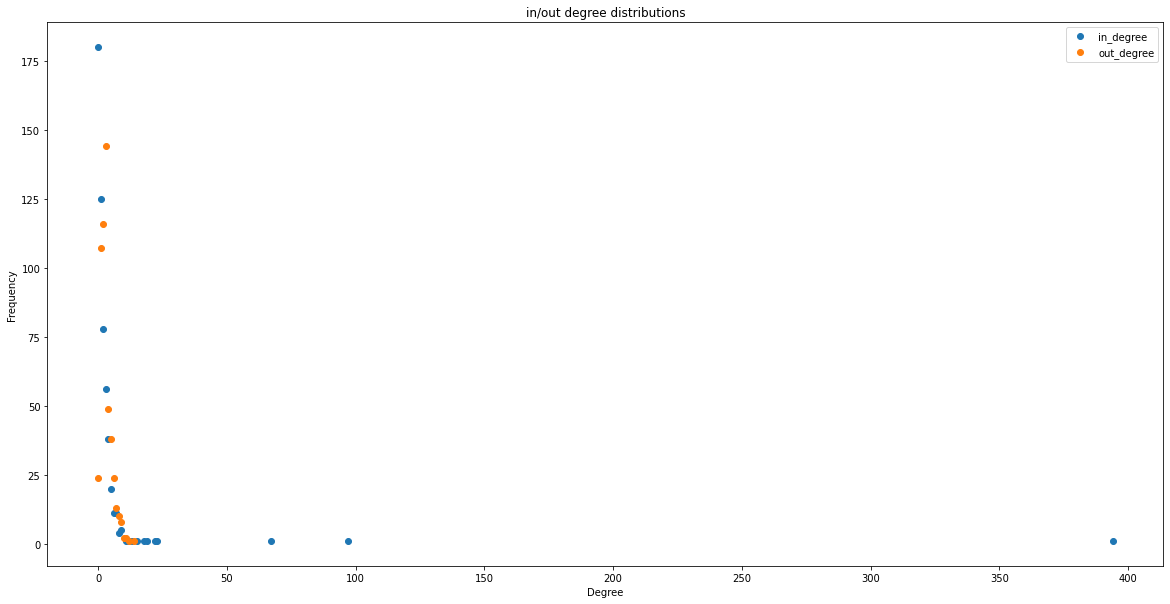

In [19]:
fig = plt.figure(figsize=(20, 10))
plotDegree(in_degree_sequence, label='in_degree')
plotDegree(out_degree_sequence, label='out_degree')

fig.show()

 * What do you observe? 
 * Can you explain why the in-degree distribution is different from the out-degree distribution?

 From looking at the in_degree distribution and the out_degree distribution, we can see that outward links in the wikis are quite similar which is expected as all wiki pages would be of similar lengths and the in degree distribution is much more varied so some characters whcih are the main characters are referred way more than the other characters which is expected as well. 

In [20]:
degree_sequence = sorted([d for n, d in DG.degree()], reverse=True)

def logPlot(degree_sequence):
    counter = collections.Counter(degree_sequence)
    x, y = [], []
    for key, value in counter.items():
        x.append(key)
        y.append(value)

    plt.title('Degree Distribution(Log-Log)')
    plt.xlabel("Degree")
    plt.ylabel("Frequency")
    plt.loglog(x, y, 'o')


def histPlot(degree_sequence):
    vec = [i for i in range(min(degree_sequence), max(degree_sequence) + 1)]
    hx, hy, _ = plt.hist(degree_sequence, bins=vec)
    plt.bar(hy[:-1], hx)
    plt.title('Histogram of the degree distribution')
    plt.xlabel("Degree")
    plt.ylabel("Frequency")

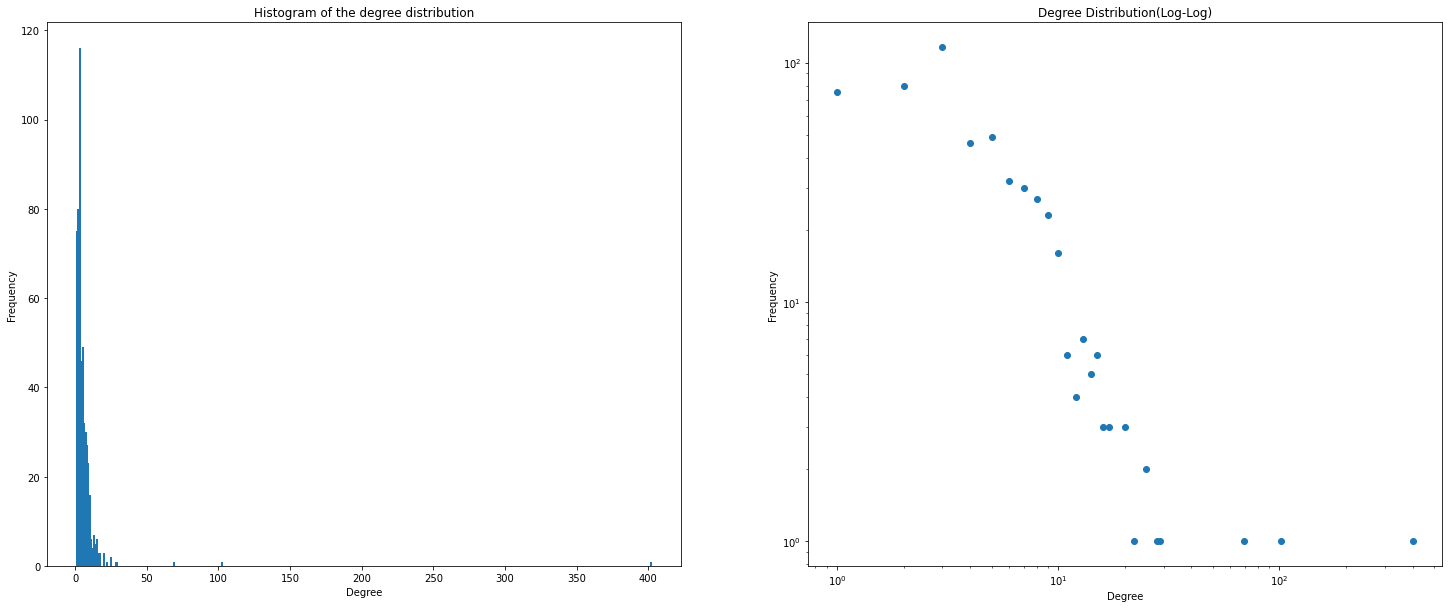

In [21]:
# Degree distribution of Characters

f = plt.figure(figsize=(25,10))
plt.subplot(1,2,1)
histPlot(degree_sequence)
plt.subplot(1,2,2)
logPlot(degree_sequence)
f.show()


> 

* Find the exponent of the degree distribution (by using the `powerlaw` package) for the in- and out-degree distribution. What does it say about our network?

In [22]:
import powerlaw
in_fit = powerlaw.Fit(in_degree_sequence)
out_fit = powerlaw.Fit(out_degree_sequence)


Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit
/root/venv/lib/python3.7/site-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
Values less than or equal to 0 in data. Throwing out 0 or negative values
Calculating best minimal value for power law fit


In [23]:
print(f"Exponent for in_degree distribution is {in_fit.power_law.alpha} ")
print(f"Exponent for out_degree distribution is {out_fit.power_law.alpha} ")

Exponent for in_degree distribution is 3.2920184571527673 
Exponent for out_degree distribution is 4.3299637752943685 


For this network, both the first and the second moments are finite. For all practical purposes the properties of a scale-free network in this regime are difficult to distinguish from the properties a random network of similar size. 

Also its highly unlikely its a real network is we dont find higher exponent than 3 in real networks.


> * Compare the degree distribution of the undirected graph to a *random network* with the same number of nodes and probability of connection *p*. Comment your results.

In [24]:
N = len(DG.nodes)
k = sum(degree_sequence) / N
p = k / (N - 1)

randomG = nx.generators.random_graphs.erdos_renyi_graph(N, p)
random_degree_sequence = sorted([d for n, d in randomG.degree()], reverse=True)

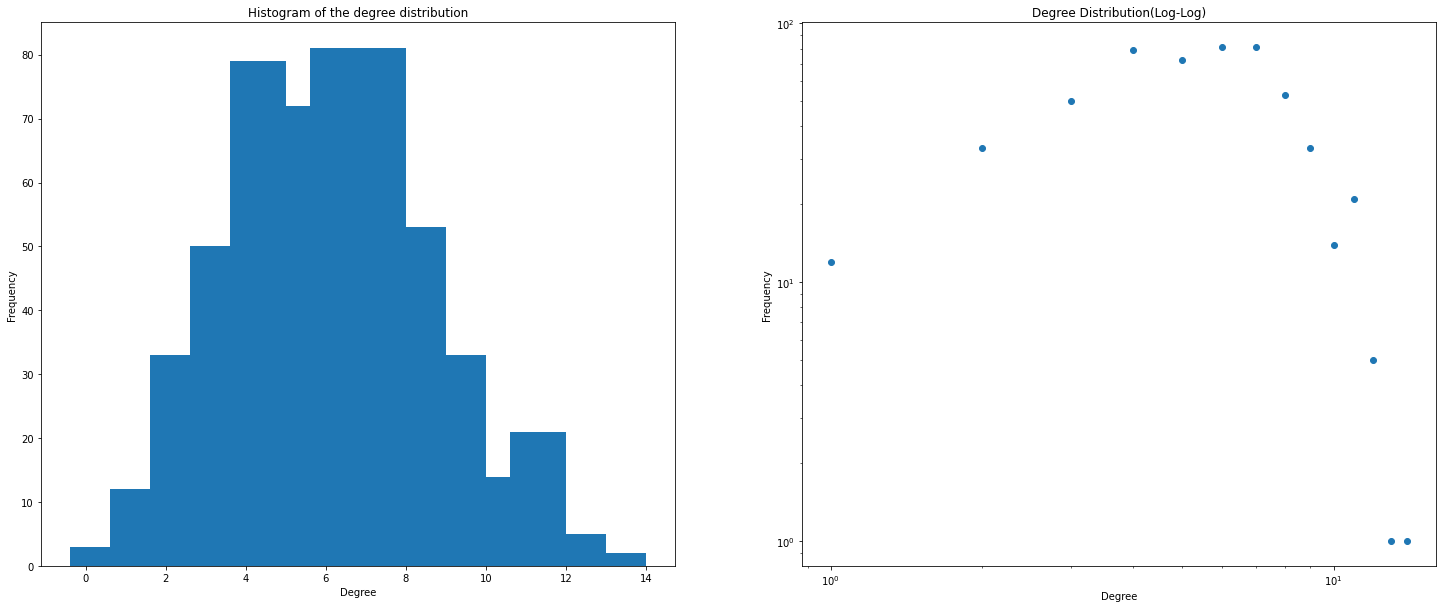

In [25]:
f = plt.figure(figsize=(25,10))
plt.subplot(1,2,1)
histPlot(random_degree_sequence)
plt.subplot(1,2,2)
logPlot(random_degree_sequence)
f.show()

# Part 1: Network visualization and basic stats

Visualize the network (from lecture 5) and calculate stats (from lecture 4 and 5). For this exercise, we assume that you've already generated the BotW network and extracted the giant connected component. Use the GCC to report the results.


### Exercise 1b: Visualization (see lecture 5 for more hints)

> * Create a nice visualization of the total (undirected) network:
>   * Color nodes according to the role;
>   * Scale node-size according to degree;
>   * Get node positions based on the Force Atlas 2 algorithm;
>   * Whatever else you feel like that would make the visualization nicer.


In [26]:
largest_cc = max(nx.algorithms.components.weakly_connected_components(DG), key=len)

In [27]:
def createSubGraph(G, largest_wcc):
    # Create a subgraph SG based on a (possibly multigraph) G
    SG = G.__class__()
    SG.add_nodes_from((n, G.nodes[n]) for n in largest_wcc)
    if SG.is_multigraph():
        SG.add_edges_from((n, nbr, key, d)
            for n, nbrs in G.adj.items() if n in largest_wcc
            for nbr, keydict in nbrs.items() if nbr in largest_wcc
            for key, d in keydict.items())
    else:
        SG.add_edges_from((n, nbr, d)
            for n, nbrs in G.adj.items() if n in largest_wcc
            for nbr, d in nbrs.items() if nbr in largest_wcc)
    SG.graph.update(G.graph)
    return SG

In [28]:
subDG = createSubGraph(DG, largest_cc)

In [29]:
G = subDG.to_undirected()

In [30]:
colorParm = []
node_sizes = []
degree_dict = {n: d for n, d in G.degree()}
for node in G.nodes():
    if G.nodes[node]['role'] == "Allies":
        colorParm.append("#0000ff") # Allies in blue
    elif G.nodes[node]['role'] == "Enemies":
        colorParm.append("#ff0000") # Enemies in red
    elif G.nodes[node]['role'] == "Bosses":
        colorParm.append("#aa00aa") #  Bosses in purple
    else:
        colorParm.append("#c7c7c7")
    node_sizes.append(degree_dict[node])

In [31]:
forceatlas2 = ForceAtlas2(
                        # Behavior alternatives
                            outboundAttractionDistribution=False,
                            edgeWeightInfluence=0.6,
                        # Performance
                            jitterTolerance=0.3, # Tolerance
                            barnesHutOptimize=True,
                            barnesHutTheta=0.6,
                        # Tuning
                            scalingRatio=2.0,
                            strongGravityMode=False,
                            gravity=1.0,
                        # Log
                            verbose=True
)

new_node_sizes = [x * 10 for x in node_sizes]
positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=1000)

100%|██████████| 1000/1000 [00:05<00:00, 179.71it/s]BarnesHut Approximation  took  1.17  seconds
Repulsion forces  took  4.01  seconds
Gravitational forces  took  0.02  seconds
Attraction forces  took  0.06  seconds
AdjustSpeedAndApplyForces step  took  0.12  seconds



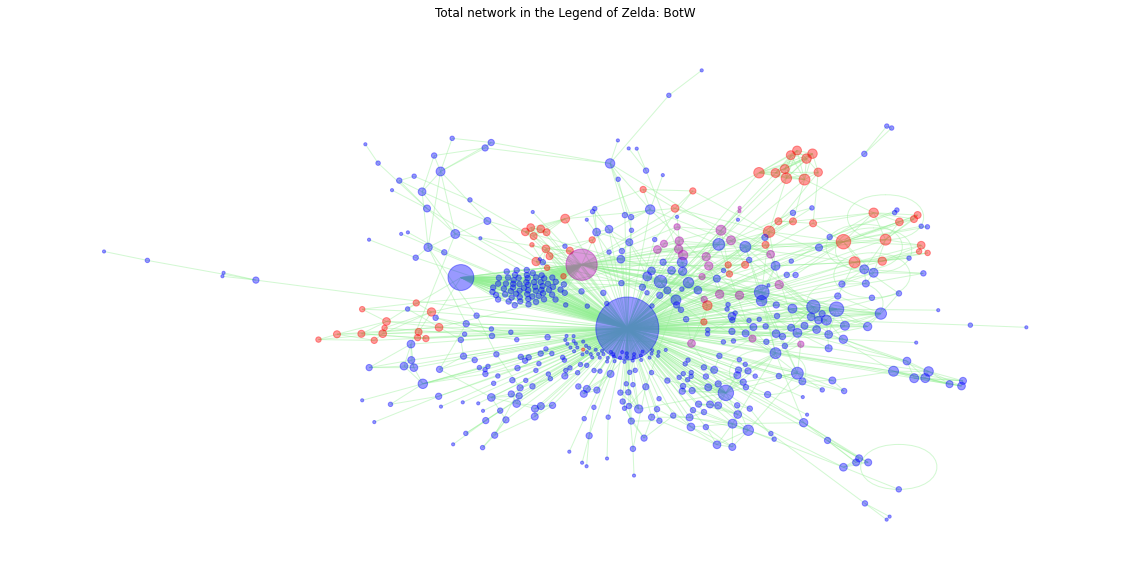

In [32]:
fig = plt.figure(figsize=(20, 10))
nx.draw_networkx_nodes(G, positions, node_size=new_node_sizes, node_color=colorParm, alpha=0.4)
nx.draw_networkx_edges(G, positions, edge_color="lightgreen", alpha=0.4)
plt.title("Total network in the Legend of Zelda: BotW")
plt.axis('off')
fig.show()

> * Describe the structure you observe. Can you identify nodes with a privileged position in the network? Do you observe chains of connected nodes? Do you see any interesting group of nodes (can you guess who's involved)?

We can see that ther are a 3 highly connected nodes which are probably the main characters Link(allies), Zelda(allies) and   Calamity Ganon. Link is probably in the priviliged position as he is connected to most characters. The 3 nodes act like hubs too for the network. 

# Part 2: Word-clouds

Create your own version of the word-clouds (from lecture 7). For this exercise we assume you know how to download and clean text from the ZeldaWiki pages.

Here's what you need to do:
> * Create a word-cloud for each race of the [five champions of Hyrule](https://zelda.fandom.com/wiki/Champions) (i.e. Hylian, Zora, Goron, Gerudo, and Rito) according to either TC-IDF. Feel free to make it as fancy as you like. Explain your process and comment on your results.

In [33]:
#nltk.download()

In [34]:
character_titles= df_characters.Name

character_title_match= [word.lower() for word in character_titles] 
stopword_english= stopwords.words('english'),

def cleaning_up_text(temp):
    temp= re.sub("^==(.+?)==","",temp)
    temp=temp.split('Locations')[0]
    temp=temp.split('Nomenclature')[0]

    temp=temp.split('See Also')[0]
    temp=temp.split('Gallery')[0]
    temp = temp.lower()
    temp=re.sub(r'[^\w\s]',"  ",temp)
    for title in character_title_match:
        pattern= title #+"(s)?"
        re.sub(pattern," ", temp)

    querywords = temp.split()
    new_text=""
    for w in querywords:
        if len(w) > 1:
            new_text = new_text + " " + w
    querywords = new_text.split()
    new_text=""
    for word in querywords:
        if word not in stopword_english:
            new_text = new_text + " " + word
    return(new_text)



In [35]:
Hylian_list,Zora_list,Goron_list,Gerudo_list,Rito_list=[],[],[],[],[]
def add_to_race_list(race,tokens):
    if race == 'Hylian':
        return Hylian_list.extend(tokens)
    elif(race=="Zora"):
        return Zora_list.extend(tokens)
    elif(race=="Goron"):
        return Goron_list.extend(tokens)
    elif(race=="Gerudo"):
        return Gerudo_list.extend(tokens)
    elif(race=="Rito"):
        return Rito_list.extend(tokens)

In [36]:
#punctuations = '(''!()-[]{};:'"\,<>./?@#$%^&*_~'')'

wnl=nltk.WordNetLemmatizer()

character_titles=[re.sub(" ", "_", x) for x in character_titles]

character_race= df_characters.race

i=0
for i in range(len(character_titles)):
    name = character_titles[i]
    try:
        with open('./Characters' + '/' + name + '.txt', 'r') as f:
            text = f.read()
            text=cleaning_up_text(text)
            text=wnl.lemmatize(text)
            tokens = word_tokenize(text)
            race= character_race[i]
            add_to_race_list(race,tokens)
    except FileNotFoundError as e:
        pass



In [37]:
# Creating 5 dictionaries using the above tokens as keys and the count of occurance as values.
Hylian_dictionary, Zora_dictionary, Goron_dictionary, Gerudo_dictionary, Rito_dictionary = collections.Counter(Hylian_list), collections.Counter(Zora_list), collections.Counter(Goron_list), collections.Counter(Gerudo_list), collections.Counter(Rito_list)

In [38]:
# Hylian_ndocs= len(Hylian_list)
# Zora_ndocs= len(Zora_list)
# Goron_ndocs= len(Goron_list)
# GerudoHylian_ndocs= len(Gerudo_list)
# Rito_ndocs= len(Rito_list)

# def getIDF(word, race):
    

def getTF(word, race):
    if race == 'Hylian':
        return Hylian_dictionary[word] if word in Hylian_dictionary else 0
    elif(race=="Zora"):
        return Zora_dictionary[word] if word in Zora_dictionary else 0
    elif(race=="Goron"):
        return Goron_dictionary[word] if word in Goron_dictionary else 0
    elif(race=="Gerudo"):
        return Gerudo_dictionary[word] if word in Gerudo_dictionary else 0
    elif(race=="Rito"):
        return Rito_dictionary[word] if word in Rito_dictionary else 0

def getWeight(word, race):

    Hylian_freq= getTF(word,"Hylian")
    Zora_freq= getTF(word,"Zora")
    Goron_freq= getTF(word,"Goron")
    Gerudo_freq= getTF(word,"Gerudo")
    Rito_freq= getTF(word,"Rito")

    count= 0

    if(Hylian_freq>0):
        count=count+1
    if(Zora_freq>0):
        count=count+1
    if(Goron_freq>0):
        count=count+1
    if(Gerudo_freq>0):
        count=count+1
    if(Rito_freq>0):
        count=count+1


    if race == 'Hylian':
        return Hylian_freq *(math.log(5/count))
    elif(race=="Zora"):
        return Zora_freq **(math.log(5/count))
    elif(race=="Goron"):
        return Goron_freq *(math.log(5/count))
    elif(race=="Gerudo"):
        return Gerudo_freq *(math.log(5/count))
    elif(race=="Rito"):
        return Rito_freq *(math.log(5/count))

In [39]:


HylianTF_IDF = sorted([(word, getWeight(word, 'Hylian')) for word in Hylian_dictionary.keys()], key=lambda x: x[1], reverse=True)

ZoraTF_IDF = sorted([(word, getWeight(word, 'Zora')) for word in Zora_dictionary.keys()], key=lambda x: x[1], reverse=True)

GoronTF_IDF = sorted([(word, getWeight(word, 'Goron')) for word in Goron_dictionary.keys()], key=lambda x: x[1], reverse=True)

GerudoTF_IDF = sorted([(word, getWeight(word, 'Gerudo')) for word in Gerudo_dictionary.keys()], key=lambda x: x[1], reverse=True)

RitoTF_IDF = sorted([(word, getWeight(word, 'Rito')) for word in Rito_dictionary.keys()], key=lambda x: x[1], reverse=True)


In [40]:
def getLongText(lst):
    text = ""
    for key, val in lst:
        text += (key + " ") * math.ceil(val)
    return text

def plotWordCloud(text):
    fig = plt.figure(figsize=(20, 10))
    wordcloud = WordCloud(collocations=False, max_words=100).generate(text)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    fig.show()

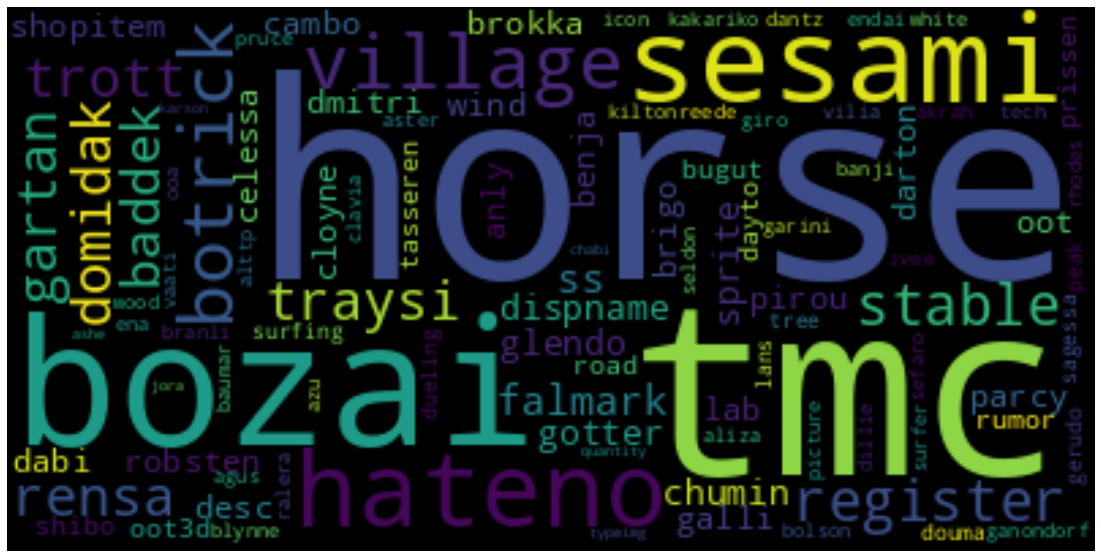

In [41]:
plotWordCloud(getLongText(HylianTF_IDF))

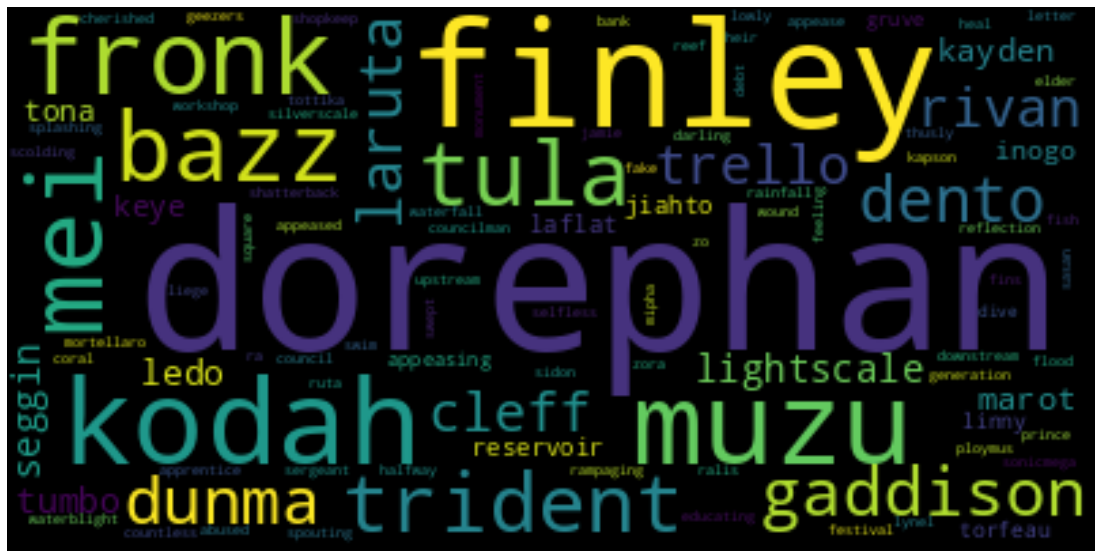

In [42]:
plotWordCloud(getLongText(ZoraTF_IDF))

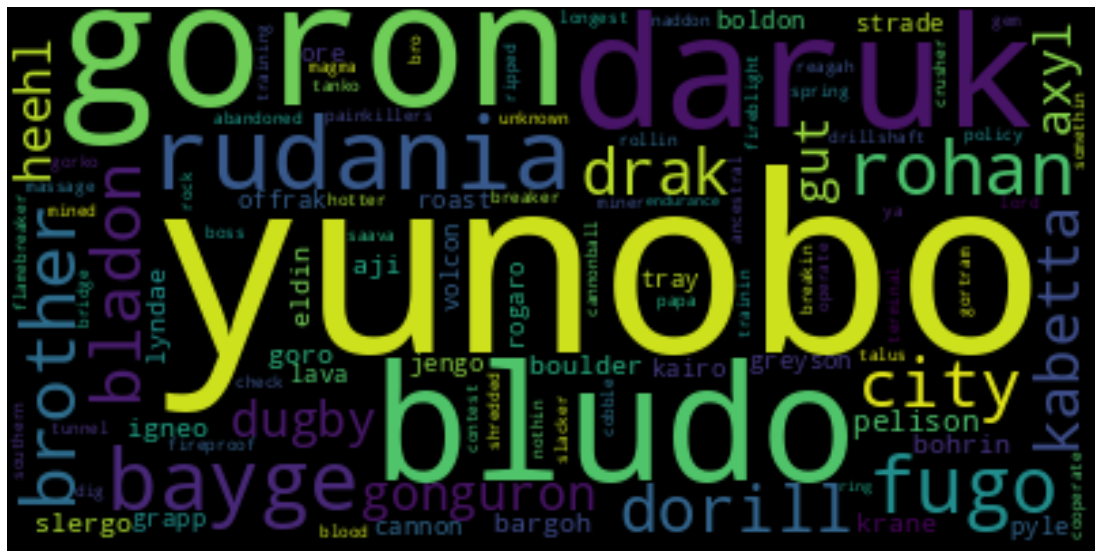

In [43]:
plotWordCloud(getLongText(GoronTF_IDF))

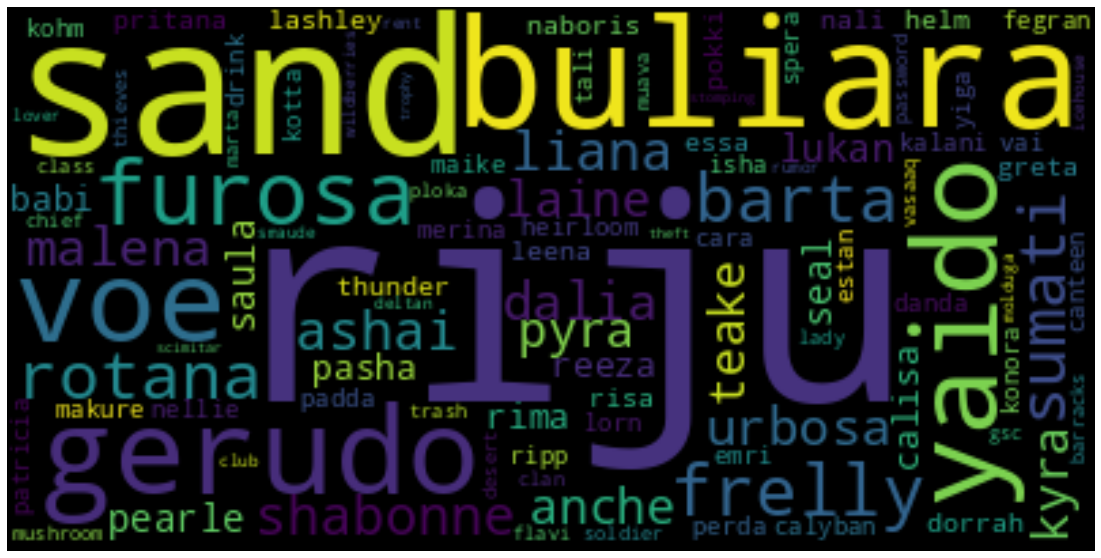

In [44]:
plotWordCloud(getLongText(GerudoTF_IDF))

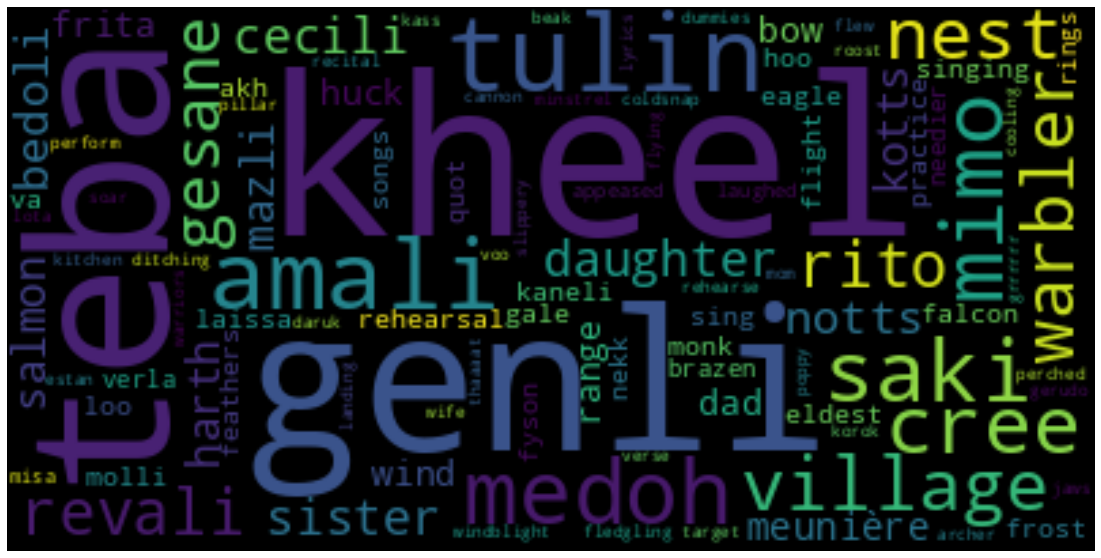

In [45]:
plotWordCloud(getLongText(RitoTF_IDF))

# Part 3: Communities and TF-IDF

Find communities and compute their associated TF-IDF (from lecture 7 and 8).

Here's what you need to do:
> * Explain the Louvain algorithm and how it finds communities in a newtork.

The **Louvain algorithm** works by initially optimizing the modularity and then, communities are aggregated based on their 'inter-community' links. The modularity is optimized by first creating a number of random communities. Next, nodes are removed from - inserted into a different community, until no significant increase in modularity is seen. The communities are aggregated by creating 'giant nodes', from each community. The modularity is then optimized with inner-community links, represented as self-loop and links from other communities, represented as weighted links.



> * Explain how you chose to identify the communities: Which algorithm did you use? (if you did not use the Louvain method, explain how the method you have used works).

We used Louvain method to find the communities in the network. How it works is explained above


In [46]:
def communities(graph):
    louvain_partition = community_louvain.best_partition(graph)
    d = collections.defaultdict(list)

    #print(community_louvain.modularity(louvain_partition,graph))
    
    # Mapping the nodes 
    for com in set(louvain_partition.values()):
        for nodes in louvain_partition.keys():
            if louvain_partition[nodes] == com:
                d[com].append(nodes)
    
    return list(d.values())

In [47]:

all_communities= communities(G) # G is the undirected GCC, calcualted in part 1(b)

>**Comment your results:**
>   - How many communities did you find in total?



In [48]:
print(f"The number of communities in --> {len(all_communities)}")

The number of communities in --> 20


>* Compute the value of modularity with the partition created by the algorithm.


In [49]:
nx.algorithms.community.quality.modularity(G, all_communities)

0.5797485948620112

> * Plot the distribution of community sizes.

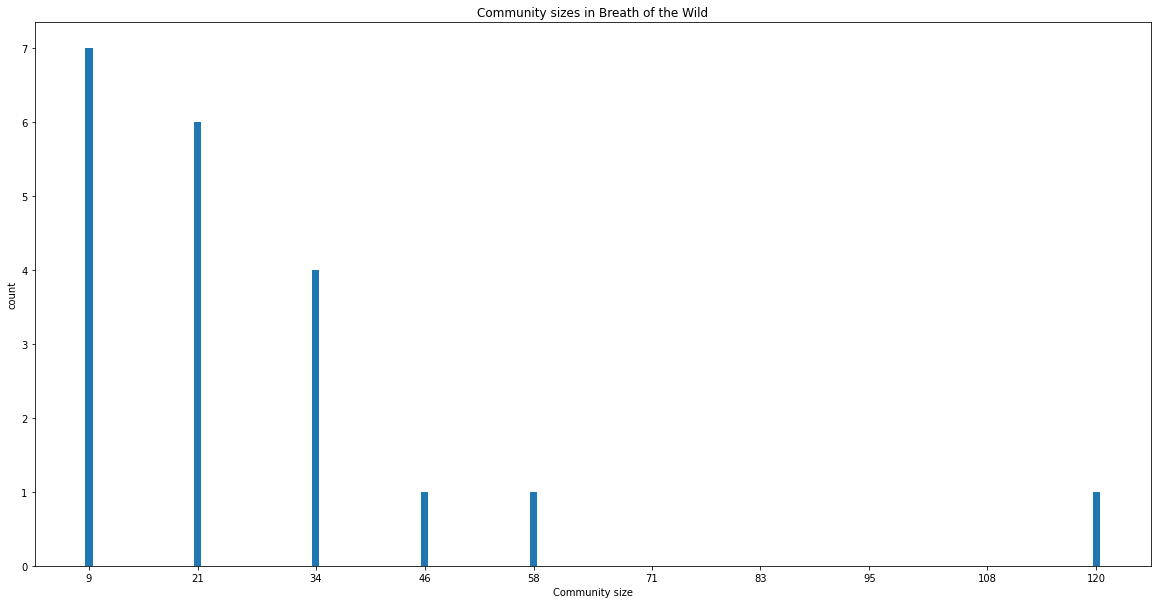

In [50]:
hist, bin_edges = np.histogram(list(len(com) for com in all_communities))
center = ((bin_edges[:-1] + bin_edges[1:]) / 2).round()
fig = plt.figure(figsize=(20, 10))
plt.bar(center, hist)
plt.title("Community sizes in Breath of the Wild")
plt.ylabel("count")
plt.xlabel("Community size")
plt.xticks(center)
fig.show()

> * For the 5 largest communities, create TF-IDF based rankings of words in each community. 
>   * There are many ways to calculate TF-IDF, explain how you've done it and motivate your choices.


The method we used for for calculationg  Term Frequency was the sum of the times the word appears in the text divided by the number of words in the text. We did this for each community seperately.

The way we calculated TF-IDF was by first create a set of unique word list for each community. Then we calculated the document frequency of each unique word, which was the number of documents the word appeared within their community. Then we calcualted the TF-IDF by dividing the total number of documents in each community by (document frequency +1) and then we taking the natural algorithm of this fraction.  We added 1 to the denominator just to prevent a division by 0 in an unlikely scenario. 


We calculated the TF and IDF for each top community seperately. 

In [51]:
top5_communities = sorted(all_communities, key=len, reverse=True)[:5]

top5_communities_member_number= [ len(x) for x in top5_communities ]

In [52]:
def community_text(titles):
    text_list=[]
    titles= [re.sub(" ","_",x) for x in titles]
    for i in range(len(titles)):
        name = titles[i]

        try:
            with open('./Characters' + '/' + name + '.txt', 'r') as f:
                text = f.read()
                text=cleaning_up_text(text)
                text=wnl.lemmatize(text)
                tokens = word_tokenize(text)
                text_list.append(tokens)
        except FileNotFoundError as e:
            pass
    return(text_list)


In [53]:
top5_communities_text = [ community_text(x) for x in top5_communities]


In [54]:
DF = [{},{},{},{},{}]
i=0
for text in top5_communities_text:
    for j in range(len(text)):
        tokens = text[j]
        for w in tokens:
            try:
                DF[i][w].add(j)
            except:
                DF[i][w] = {j}
    i=i+1

In [55]:
total_vocab=[]
for df_comm in DF:
    total_vocab.append(([x for x in df_comm]))
    for j in df_comm:
        df_comm[j]= len(df_comm[j])

In [56]:
TF = [{},{},{},{},{}]
i=0
total_words=[0,0,0,0,0]
for text in top5_communities_text:
    for j in range(len(text)):
        tokens = text[j]
        for w in tokens:
            total_words[i]=total_words[i]+1
            if w in TF[i]:
                TF[i][w]= TF[i][w]+1
            else:
                TF[i][w]= 1
    i=i+1

In [57]:
tf_idf=[{},{},{},{},{}]
for i in range(5):
    vocab= total_vocab[i]
    for token in vocab:
        TF[i][token]= TF[i][token]/total_words[i]
        n=top5_communities_member_number[i]
        df_num=DF[i][token]+1
        tf_idf[i][token]= TF[i][token]* (n/(df_num))

    

In [58]:

TF_IDF= [dict(sorted(x.items(), key=lambda item: item[1], reverse=True)[:5]) for x in tf_idf]

TF= [dict(sorted(x.items(), key=lambda item: item[1], reverse=True)[:5]) for x in TF]

>   * List the 5 top words for each community according to TF.
>   * List the 5 top words for each community accourding to TF-IDF. Are these words more descriptive of the community than just the TF? Justify your answer.

In [59]:


for index in range(len(TF)):

    ans1=list(TF[index].keys())
    ans2=list(TF_IDF[index].keys())
    print(f"Top 5 for the {(index+1)} community according to TF are ->{ans1} ")
    print(f"Top 5 for the {(index+1)} community according to TF-IDF are -> {ans2} ")
    print("\n")


Top 5 for the 1 community according to TF are ->['botw', 'the', 'ref', 'to', 'link'] 
Top 5 for the 1 community according to TF-IDF are -> ['tmc', 'zelda', 'botw', 'the', 'ref'] 


Top 5 for the 2 community according to TF are ->['botw', 'term', 'the', 'link', 'ref'] 
Top 5 for the 2 community according to TF-IDF are -> ['ss', 'botw', 'term', 'the', 'link'] 


Top 5 for the 3 community according to TF are ->['the', 'botw', 'ref', 'to', 'of'] 
Top 5 for the 3 community according to TF-IDF are -> ['the', 'botw', 'ref', 'to', 'koko'] 


Top 5 for the 4 community according to TF are ->['ref', 'botw', 'the', 'to', 'cite'] 
Top 5 for the 4 community according to TF-IDF are -> ['ref', 'botw', 'the', 'traysi', 'center'] 


Top 5 for the 5 community according to TF are ->['botw', 'ref', 'the', 'link', 'term'] 
Top 5 for the 5 community according to TF-IDF are -> ['botw', 'ref', 'the', 'gruve', 'link'] 




# Part 4: Sentiment of communities

Analyze the sentiment of the communities (lecture 8). Here, we assume that you've successfully identified communities.  More tips & tricks can be found, if you take a look at Lecture 8's exercises.

A couple of additional instructions you will need below:
* We name each community by its three most connected characters.
* Average the average sentiment of the nodes in each community to find a community level sentiment.

In [60]:
 from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [61]:
community_names = [", ".join(sorted([node for node in com], key=lambda x: G.degree(x), reverse=True)[:3]) for com in all_communities]

In [62]:
# First download the dataset with the happiness average
# We used this list here: https://hedonometer.org/words/labMT-en-v2/ 
# Reference: How the world's collective attention is being paid to a pandemic: COVID-19 related 1-gram time series for 24 languages on Twitter. --> https://arxiv.org/abs/2003.12614

happiness = './Hedonometer.csv'
happy_words = pd.read_csv(happiness)

In [63]:
hw= (happy_words['Word in English']).tolist()
hs= (happy_words['Happiness Score']).tolist()

def calc_average_sentiment(tokens):
    sentiment=0.0
    count=1
    for token in tokens:
        if(token in hw):
            sentiment= sentiment+ hs[hw.index(token)]
            count=count+1

    sentiment= sentiment/count

    return(sentiment)



In [65]:
def community_text_MT(titles):
    text_list=[]
    titles= [re.sub(" ","_",x) for x in titles]
    for i in range(len(titles)):
        name = titles[i]

        try:
            with open('./Characters' + '/' + name + '.txt', 'r') as f:
                text = f.read()
                text=cleaning_up_text(text)
                text=wnl.lemmatize(text)
                tokens = word_tokenize(text)
                text_list.append(tokens)
        except FileNotFoundError as e:
            pass
    return(text_list)

In [66]:
def community_text_VADER(titles):
    text_list=[]
    titles= [re.sub(" ","_",x) for x in titles]
    for i in range(len(titles)):
        name = titles[i]

        try:
            with open('./Characters' + '/' + name + '.txt', 'r') as f:
                text = f.read()
                text=wnl.lemmatize(text)
                tokens = word_tokenize(text)
                text_list.append(tokens)
        except FileNotFoundError as e:
            pass
    return(text_list)

In [67]:
VADER_all_characters_text= community_text_VADER(character_titles)

In [69]:
i=0
sentiment_value_vader={}
analyzer = SentimentIntensityAnalyzer()
for character in character_titles:
    text = VADER_all_characters_text[i]
    newstr=""
    for word in text:
        newstr= newstr+ word+" "
    sentiment_value_vader[character]= analyzer.polarity_scores(newstr)
    i+=1


In [70]:
MT_all_characters_text= community_text_MT(character_titles)

In [71]:
i=0
sentiment_value_MT={}
for character in character_titles:
    text = MT_all_characters_text[i]
    sentiment_value_MT[character]= calc_average_sentiment(text)
    i+=1

In [72]:
sentiment_value_MT= sorted(sentiment_value_MT.items(), key=lambda item: item[1], reverse=True)
sentiment_value_VADER= sorted(sentiment_value_vader.items(), key=lambda item: item[1].get("compound"), reverse=True)

Here's what you need to do (repeat these steps and report your results for **both LabMT and VADER**):
> * Calculate and store sentiment for every character
> * Create a histogram of all character's associated sentiments.
> * What are the 10 characters with happiest and saddest pages?

In [73]:
sentiment_value_MT_dict= dict(sentiment_value_MT)

In [74]:
sentiment_value_vader_dict={}
sentiment_value_vader_plot=[]
for name in sentiment_value_vader:
    t= sentiment_value_vader[name].get("compound")
    sentiment_value_vader_dict[name]= t
    sentiment_value_vader_plot.append(t)

sentiment_value_vader_dict= sorted(sentiment_value_vader_dict.items(), key=lambda item: item[1], reverse=True)
sentiment_value_vader_dict= dict(sentiment_value_vader_dict)

In [75]:


plot_sentiment_value_MT= [x[1]for x in sentiment_value_MT ]

Text(0.5, 0, 'Sentiment values')

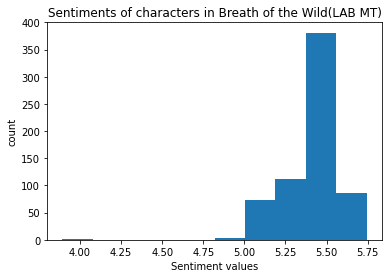

In [76]:
plt.hist(plot_sentiment_value_MT)
plt.title("Sentiments of characters in Breath of the Wild(LAB MT)")
plt.ylabel("count")
plt.xlabel("Sentiment values")

Text(0.5, 0, 'Sentiment values')

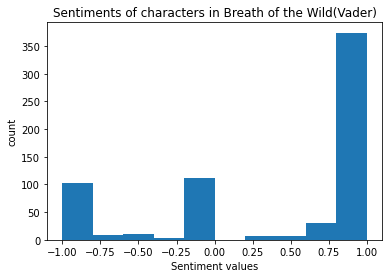

In [88]:
plt.hist(sentiment_value_vader_plot)
plt.title("Sentiments of characters in Breath of the Wild(Vader)")
plt.ylabel("count")
plt.xlabel("Sentiment values")

In [77]:
ans1=list((dict(sentiment_value_MT[:5])).keys())
ans2=list(sentiment_value_vader_dict.keys())[:5]
ans3=list((dict(sentiment_value_MT[651:656])).keys())
ans4=list(sentiment_value_vader_dict.keys())[651:656]
#ans2=list(TF_IDF[index].keys())
print(f"Ten happiest characters according to LABMT are {ans1}" )
print(f"Ten happiest characters according to VADER are {ans2}" )
print(f"Ten saddest characters according to LABMT are {ans3}" )
print(f"Ten saddest characters according to VADER are {ans4}" )

Ten happiest characters according to LABMT are ['Toffa', 'Bamboo', 'Shamae', 'Dauntless', 'Lorn']
Ten happiest characters according to VADER are ['Beedle', 'Link', 'Princess_Zelda', 'Hylia', 'The_Great_Deku_Tree']
Ten saddest characters according to LABMT are ['Dah_Hesho', 'Cursed_Lizalfos', 'Joloo_Nah', "Dow_Na'eh", 'Cherry']
Ten saddest characters according to VADER are ['Hinox', 'Chuchu', 'Fire_Keese', 'Keese', 'Moblin']


    Now, compute the sentiment of communities: 
> * What are the three happiest communities according to the LabMT wordlist approach? What about VADER?
> * What are the three saddest communities according to the LabMT wordlist approach? What about VADER?
> * Create a bar plot showing the average sentiment of each community and add error-bars using the standard deviation for both methods. 
> * Explain the difference between the two methods and compare the results you have obtained above.


In [78]:
all_communities_text = [ community_text(x) for x in all_communities]
VADER_all_communities_text = [ community_text_VADER(x) for x in all_communities]


In [105]:
i=0
senti_value=[]
sent_avg=[]
sent_std=[]
for community in  all_communities:
    j=0;
    sent_avg.append(0)
    senti_value.append({})
    sent_std.append(0)
    list_std=[]
    for name in community:
        text_page= all_communities_text[i][j]
        senti_value[i][name]= calc_average_sentiment(text_page)
        j+=1
        sent_avg[i]= sent_avg[i] + senti_value[i][name]
        list_std.append(senti_value[i][name])
    sent_avg[i]= sent_avg[i]/j
    sent_std[i]= np.std(list_std)
    i+=1


In [106]:
senti_value_VADER=[]
sent_avg_VADER=[]
sent_std_VADER=[]

list_sentences=[]
for vader_text in  VADER_all_communities_text:
    whole_text= []
    for character in vader_text:
        string=""
        for word in character:
            string= string+ word+ " "
        whole_text.append(string)
    list_sentences.append(whole_text)
analyzer = SentimentIntensityAnalyzer()
# vs={}
i=0
for community in  all_communities:
    j=0;
    sent_avg_VADER.append(0)
    sent_std_VADER.append(0)
    senti_value_VADER.append({})
    list_std=[]
    for name in community:
        sentence= list_sentences[i][j]
        senti_value_VADER[i][name]= analyzer.polarity_scores(sentence)
        sent_avg_VADER[i]= sent_avg_VADER[i] + senti_value_VADER[i][name].get("compound")
        list_std.append(senti_value_VADER[i][name].get("compound"))
        j+=1
    sent_std_VADER[i]= np.std(list_std)
    sent_avg_VADER[i]= sent_avg_VADER[i]/j
    i=i+1


In [107]:
top3_MT_happy= sorted(range(len(sent_avg)), key=lambda i: sent_avg[i])[-3:]
top3_vader_happy= sorted(range(len(sent_avg_VADER)), key=lambda i: sent_avg_VADER[i])[-3:]
top3_MT_sad= sorted(range(len(sent_avg)), key=lambda i: sent_avg[i])[:3]
top3_vader_sad= sorted(range(len(sent_avg_VADER)), key=lambda i: sent_avg_VADER[i])[:3]

In [108]:
print("Top 3 happiest communities according to LABMT are")
for i in top3_MT_happy:
    print(community_names[i])

Top 3 happiest communities according to LABMT are
Azu, Amira, Narah
Baddek, Nazbi, Dauntless
Epona, Dmitri, Tenne


In [109]:
print("Top 3 happiest communities according to VADER are")
for i in top3_vader_happy:
    print(community_names[i])

Top 3 happiest communities according to VADER are
Epona, Dmitri, Tenne
Ashai, Pearle, Rotana
Baumar, Falmark, Bamboo


In [110]:
print("Top 3 sad communities according to LABMT are")
for i in top3_MT_sad:
    print(community_names[i])

Top 3 sad communities according to LABMT are
Stalizalfos, Silver Lizalfos, Lizalfos
Guardian Stalker, Decayed Guardian, Guardian Turret
Fire Keese, Fire Chuchu, Chuchu


In [111]:
print("Top 3 sad communities according to LABMT are")
for i in top3_vader_sad:
    print(community_names[i])

Top 3 sad communities according to LABMT are
Stalizalfos, Silver Lizalfos, Lizalfos
Moblin, Lynel, Sky Octorok
Guardian Stalker, Decayed Guardian, Guardian Turret


Text(0.5, 0, 'Community Number')

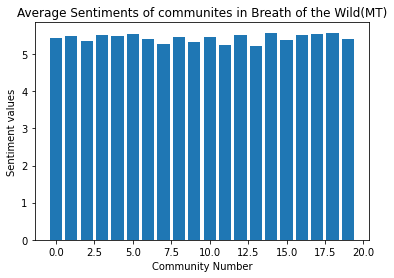

In [112]:
xs = np.arange(len(sent_avg)) 
plt.bar(xs,sent_avg)
plt.title("Average Sentiments of communites in Breath of the Wild(MT)")
plt.ylabel("Sentiment values")
plt.xlabel("Community Number")

Text(0.5, 0, 'Community Number')

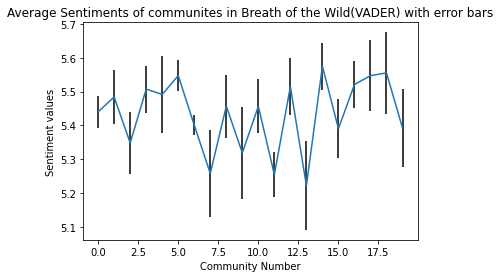

In [116]:
plt.errorbar(xs,sent_avg, sent_std,ecolor='black')
plt.title("Average Sentiments of communites in Breath of the Wild(VADER) with error bars")
plt.ylabel("Sentiment values")
plt.xlabel("Community Number")

Text(0.5, 0, 'Community Number')

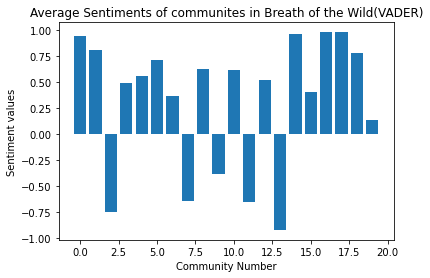

In [114]:
xs = np.arange(len(sent_avg_VADER)) 
plt.bar(xs,sent_avg_VADER)
plt.title("Average Sentiments of communites in Breath of the Wild(VADER)")
plt.ylabel("Sentiment values")
plt.xlabel("Community Number")

Text(0.5, 0, 'Community Number')

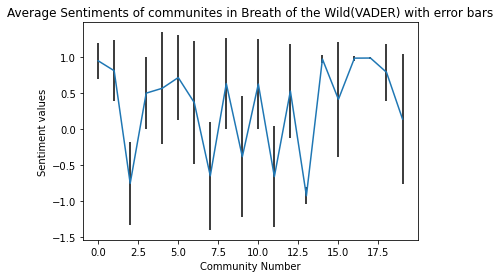

In [117]:
plt.errorbar(xs,sent_avg_VADER, sent_std_VADER,ecolor='black')
plt.title("Average Sentiments of communites in Breath of the Wild(VADER) with error bars")
plt.ylabel("Sentiment values")
plt.xlabel("Community Number")

As it can be seen by the results, the difference between the "happiest" and the "saddest" communities is very different when it comes to the the two methods. VADER seems to be a better approach as it can be seen that its create more deviation in the communities happiness index. It could be because of its abilitites to use more contexual information like capitalized texts and punctuations to better figure out the communities emotions.

> * What is the advantage of using a rule-based method over the dictionary-based approach?

Dictionary-based sentiment analysis is a computational approach to measuring the feeling that a text conveys to the reader. On the other hand, a rule-based analysis uses rules as the knowledge representation. VADER for example, which is a rule-based sentiment analysis tool is specifically attuned to sentiments expressed in social media. It is used for sentiment analysis of text which has both the polarities i.e. positive/negative.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=e8b4efb8-9abe-4446-ba5a-415d366da13d' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>